In [3]:
import pandas as pd
import os
import ast

In [1]:
def split_csv_with_pandas(input_file, output_dir, rows_per_file=100000):
    # Check if the output directory exists; if not, create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Use pandas to read the input CSV file in chunks of a specified number of rows
    chunk_iter = pd.read_csv(input_file, chunksize=rows_per_file)
    
    # Iterate over each chunk and write it to a new CSV file
    for i, chunk in enumerate(chunk_iter, start=1):
        # Generate the output file name with an incremental number
        output_file = os.path.join(output_dir, f'split_{i}.csv')
        
        # Write the chunk to a new CSV file without the index column
        chunk.to_csv(output_file, index=False)
        
        # Print confirmation message with file name and number of rows
        print(f'Wrote {output_file} with {len(chunk)} rows.')

split_csv_with_pandas('all_compounds.csv', 'data', rows_per_file=100000)

Wrote data\split_1.csv with 100000 rows.
Wrote data\split_2.csv with 100000 rows.
Wrote data\split_3.csv with 100000 rows.
Wrote data\split_4.csv with 100000 rows.
Wrote data\split_5.csv with 100000 rows.
Wrote data\split_6.csv with 100000 rows.
Wrote data\split_7.csv with 100000 rows.
Wrote data\split_8.csv with 100000 rows.
Wrote data\split_9.csv with 100000 rows.
Wrote data\split_10.csv with 100000 rows.
Wrote data\split_11.csv with 100000 rows.
Wrote data\split_12.csv with 100000 rows.
Wrote data\split_13.csv with 100000 rows.
Wrote data\split_14.csv with 100000 rows.
Wrote data\split_15.csv with 100000 rows.
Wrote data\split_16.csv with 100000 rows.
Wrote data\split_17.csv with 100000 rows.
Wrote data\split_18.csv with 100000 rows.
Wrote data\split_19.csv with 100000 rows.
Wrote data\split_20.csv with 100000 rows.
Wrote data\split_21.csv with 100000 rows.
Wrote data\split_22.csv with 100000 rows.
Wrote data\split_23.csv with 100000 rows.
Wrote data\split_24.csv with 100000 rows.
W

In [4]:
source = "data/split_1.csv"
data = pd.read_csv(source, skiprows=range(1, 100), nrows=10)

In [9]:
print(data)

      cid                                        coordinates  \
0  199519  [3.2028197679514427, 2.0422098520452945, -1.74...   
1  173847  [2.5716098136891787, -1.20129991298961, -0.298...   
2  166366  [0.17983998695333422, 0.8059099416286907, -1.3...   
3  162055  [-1.1180199190009183, 0.028139997964112057, 0....   
4  160691  [0.4887199645809299, -0.13087999053173754, -0....   
5  152191  [0.8761999364953023, 0.014699998924629195, -0....   
6  164333  [1.5956198843787666, 0.9113099339891257, -1.07...   
7  171233  [3.7042697315975164, 1.6232098823791536, 0.007...   
8  173631  [0.28306997946747475, -0.7224399476736976, -0....   
9  151567  [0.9412199318259142, -0.07731999441353288, -2....   

                                      atomic_numbers  \
0  [6, 7, 6, 6, 6, 6, 8, 6, 8, 6, 6, 6, 6, 6, 6, ...   
1  [6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 8, 6, ...   
2  [6, 6, 6, 6, 8, 8, 6, 6, 6, 6, 6, 6, 1, 1, 1, ...   
3  [6, 6, 6, 7, 7, 6, 6, 8, 7, 8, 8, 1, 1, 1, 1, ...   
4  [6, 6, 6, 6,

In [11]:
coords = ast.literal_eval(data["coordinates"][0])
nums = ast.literal_eval(data["atomic_numbers"][0])

print(len(coords))
print(len(nums))

135
45


In [5]:
import selfies as sf

mol = data["smiles"][0]
print(mol)
print(sf.split_selfies(sf.encoder(mol)))

CN(CCCOC(=O)C1(CCCC1)c1ccccc1)C
[C][N][Branch2][Ring1][#Branch2][C][C][C][O][C][=Branch1][C][=O][C][Branch1][#Branch1][C][C][C][C][Ring1][Branch1][C][=C][C][=C][C][=C][Ring1][=Branch1][C]


In [ ]:
print(sf.encoder(mol)

In [15]:
import selfies as sf
import networkx as nx
import re

def build_graph_from_selfies(selfies_str):
    tokens = sf.split_selfies(selfies_str)
    graph = nx.Graph()

    atom_id = 0
    current_attachment = None
    atom_stack = []
    ring_closures = {}

    bond_order_queue = [1]  # Used to store bond order for the NEXT atom

    for token in tokens:
        if token.startswith("[Branch"):
            branch_type = int(re.search(r"\d+", token).group())
            if branch_type == 1 and atom_stack:
                current_attachment = atom_stack.pop()
            elif branch_type == 2 and atom_stack:
                current_attachment = atom_stack[-1]
            continue

        elif token.startswith("[Ring"):
            ring_num = int(re.search(r"\d+", token).group())
            bond_order = bond_order_queue.pop() if bond_order_queue else 1

            if ring_num in ring_closures:
                ring_atom = ring_closures.pop(ring_num)
                graph.add_edge(current_attachment, ring_atom, order=bond_order)
            else:
                ring_closures[ring_num] = current_attachment
            continue

        # Check bond type prefixes
        bond_order = 1
        if token.startswith("[="):
            bond_order = 2
            token = "[" + token[2:]
        elif token.startswith("[#"):
            bond_order = 3
            token = "[" + token[2:]

        bond_order_queue.append(bond_order)

        # Now parse the actual atom symbol
        atom_symbol = token.strip("[]")

        # Add atom
        graph.add_node(atom_id, element=atom_symbol)

        # Connect to previous if needed
        if current_attachment is not None:
            bond_order = bond_order_queue.pop() if bond_order_queue else 1
            graph.add_edge(current_attachment, atom_id, order=bond_order)

        # Update attachment point
        atom_stack.append(current_attachment)
        current_attachment = atom_id
        atom_id += 1

    return graph


In [13]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph(graph):
    pos = nx.spring_layout(graph)  # force-directed layout
    labels = {node: data["element"] for node, data in graph.nodes(data=True)}
    edge_labels = {(u, v): d["order"] for u, v, d in graph.edges(data=True)}

    nx.draw(graph, pos, with_labels=True, labels=labels, node_color='lightblue', node_size=1000, font_size=10)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.show()


In [16]:
g = build_graph_from_selfies(sf.encoder(mol))

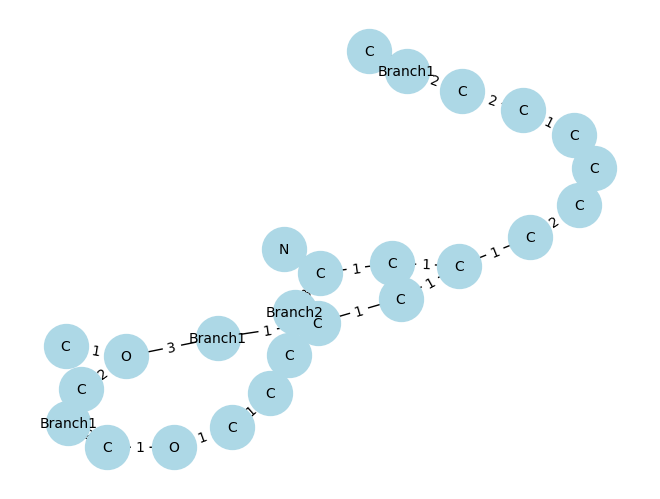

In [17]:
visualize_graph(g)

In [9]:
help(nx)

Help on package networkx:

NAME
    networkx

DESCRIPTION
    NetworkX

    NetworkX is a Python package for the creation, manipulation, and study of the
    structure, dynamics, and functions of complex networks.

    See https://networkx.org for complete documentation.

PACKAGE CONTENTS
    algorithms (package)
    classes (package)
    conftest
    convert
    convert_matrix
    drawing (package)
    exception
    generators (package)
    lazy_imports
    linalg (package)
    readwrite (package)
    relabel
    tests (package)
    utils (package)

SUBMODULES
    adjacency
    adjlist
    algebraicconnectivity
    all
    approximation
    assortativity
    astar
    asteroidal
    atlas
    attracting
    attrmatrix
    beamsearch
    bethehessianmatrix
    betweenness
    betweenness_subset
    biconnected
    binary
    bipartite
    boundary
    breadth_first_search
    centrality
    chains
    chordal
    classic
    clique
    closeness
    cluster
    cographs
    coloring
  